# Comparing NYC's Lowest Floor Elevations from the Building Elevation and Subgrade (BES) and National Flood Insurance Program (NFIP) Data Sets

Exploring the NYC Building Elevation and Subgrade (BES) Data Set in Python  

Author: Mark Bauer

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import duckdb

import requests
import json
import time

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [28]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,duckdb

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2
duckdb    : 0.10.0



# Data Set: Building Elevation and Subgrade (BES)

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [4]:
bes_df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = bes_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
bes_df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


`z_grade`: The elevation of the building at it's lowest adjacent grade - the lowest point where the building touches the ground.

`z_floor`: The elevation of what is estimated to be the lowest actively used floor.

Definitions from the data dictionary.

In [5]:
# drop all records where z_floor is zero
bes_df = (
    bes_df
    .loc[(bes_df['z_floor'] != 0) & (bes_df['z_grade'] != 0)]
    .reset_index(drop=True)
)

print('new shape of data:', bes_df.shape)
bes_df.head()

new shape of data: (847837, 26)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


Calculating Height from Building Adjacent Grade to First Floor.

In [6]:
# height from building floor to grade
bes_df['z_floor_grade'] = bes_df['z_floor'] - bes_df['z_grade']

# summary stats
bes_df['z_floor_grade'].describe()

count    847837.000000
mean          4.268165
std           3.087395
min         -50.487000
25%           2.015000
50%           3.627000
75%           6.571000
max          94.440000
Name: z_floor_grade, dtype: float64

# Data Set: The National Flood Insurance Program (NFIP)
The National Flood Insurance Program (NFIP) Policies Data for NYC.

Retrive data using the FEMA API.

In [7]:
# # set constant parameters
# BASE_URL = 'https://www.fema.gov/api/open/v2/'
# FORMAT_PARAM = '$format=json'
# METADATA_PARAM = '&$metadata=off'
# FILTER_PARAM = '&$filter=countyCode%20eq%20%27{}%27'
# SKIP_PARAM = '&$skip={}'
# TOP_PARAM = '&$top=10000'

# def get_api_url(dataset, county_fips, skip):
#     """Generate the API URL for the given dataset, county FIPS, and skip value."""
#     url_base = f'{BASE_URL}FimaNfip{dataset.capitalize()}?'
#     return f'{url_base}{FORMAT_PARAM}{METADATA_PARAM}{FILTER_PARAM}{SKIP_PARAM}{TOP_PARAM}'.format(county_fips, skip)

# def make_request(url):
#     """Make an HTTP request and handle potential errors."""
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         return response.json()
#     except requests.RequestException as e:
#         print(f"Error making request: {e}")
#         return None

# def download_data(dataset, county_fips):
#     """
#     Download FEMA NFIP policies or claims data for a specific county and save it to a JSON file.

#     Parameters:
#     - county_fips (str): County FIPS code.
#     - dataset (str): Either 'policies' or 'claims'.

#     Returns:
#     - None
#     """
#     if dataset not in {'policies', 'claims'}:
#         raise ValueError("Invalid dataset. Pass either 'policies' or 'claims' to the dataset argument")

#     if not isinstance(county_fips, str):
#         raise ValueError("County FIPS code must be passed as a string")

#     result_list = []
#     skip = 0

#     # we'll add print statements to see what's happening
#     print(f"Dataset: {dataset}")
#     print(f'County FIPS: {county_fips}\n------------')

#     while True:
#         print(f'Skip number: {skip:,}')

#         # make HTTP request and handle JSON response
#         url = get_api_url(dataset, county_fips, skip)
#         data = make_request(url)

#         dataset_name = f"FimaNfip{dataset.capitalize()}"

#         # check if the response is empty or contains an error
#         if not data or dataset_name not in data:
#             break

#         # process JSON data and extend the result list
#         result_list.extend(data[dataset_name])

#         rows = len(data[dataset_name])
#         print(f'Number of rows: {rows:,}')
#         if rows < 10000:
#             break

#         print(f'Result list length: {len(result_list):,}')
#         skip += 10000
#         time.sleep(5)

#     print(f'\nLength of the full result list: {len(result_list):,}\n')

#     # write the result list to a JSON file
#     output_filename = f"data/{dataset}-{county_fips}.json"
#     with open(output_filename, 'w') as json_file:
#         json.dump(result_list, json_file, indent=2)

Retrieve by counties in NYC.

In [8]:
# comment out for now

# download_data('policies', '36005')
# download_data('policies', '36047')
# download_data('policies', '36061')
# download_data('policies', '36081')
# download_data('policies', '36085')

In [9]:
ls data/

bes-data.parquet   nfip-data.parquet


In [10]:
# # create a DuckDB database instance
# con = duckdb.connect()

# # create table of the bes data
# con.sql(
#     """
#     CREATE TABLE nfip_data AS
#     FROM read_json('data/*.json')
#     """
# )

# # examine count of rows
# con.sql("SELECT COUNT(*) AS count_rows FROM nfip_data").show()

In [11]:
# con.sql("COPY nfip_data TO 'data/nfip-data.parquet' (FORMAT PARQUET)")

In [12]:
ls data/

bes-data.parquet   nfip-data.parquet


In [13]:
!du -h data/*

 96M	data/bes-data.parquet
 36M	data/nfip-data.parquet


In [14]:
!rm data/*.json

rm: data/*.json: No such file or directory


In [15]:
ls data/

bes-data.parquet   nfip-data.parquet


In [16]:
# create a DuckDB database instance
con = duckdb.connect()
policies_df = con.sql("SELECT * AS FROM FROM read_parquet('data/nfip-data.parquet')").df()

# examine data
print('shape of data: {}'.format(policies_df.shape))
policies_df.head()

shape of data: (522387, 81)


,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,femaRegion,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,13.0,0.0,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10473,36005,36005000400,360050004004,40.8,-73.8,68a4de8a-0dec-4c7a-9ac6-5c387f379922
1,False,NaN,NaN,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10475,36005,36005030200,360050302003,40.9,-73.8,7682eb23-b18b-4bdc-9272-7102baf543ee
2,False,NaN,2.0,None,N,False,NaN,None,0,False,...,2.0,NY,Currently Unavailable,10462,36005,36005009200,360050092002,40.8,-73.8,764a9457-b7d1-4f98-89fc-b24e4e3e4874
3,False,NaN,1.0,None,N,False,NaN,None,0,False,...,2.0,NY,Currently Unavailable,10465,36005,36005016000,360050160002,40.8,-73.8,311f657b-a7c2-4aaf-b5d7-764d5ebe4943
4,False,NaN,1.0,None,N,False,NaN,5,5,False,...,2.0,NY,Currently Unavailable,10474,36005,36005009300,360050093001,40.8,-73.9,e2c8075c-78ae-4129-91bb-de3b01fba09c


In [17]:
policies_df = (
    policies_df
    .loc[
        (policies_df['lowestFloorElevation'].notnull())
        & (policies_df['lowestFloorElevation'].between(-99, 99))]
    .reset_index(drop=True)
)

print('shape of data: {}'.format(policies_df.shape))
policies_df.head()

shape of data: (114403, 81)


,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,femaRegion,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,13.0,0.0,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10473,36005,36005000400,360050004004,40.8,-73.8,68a4de8a-0dec-4c7a-9ac6-5c387f379922
1,False,17.0,2.0,None,N,False,NaN,1,0,True,...,2.0,NY,Currently Unavailable,10465,36005,36005027402,360050274020,40.8,-73.8,356d3442-5eb9-4453-8b68-e95ff18114cc
2,False,15.0,2.0,None,N,False,NaN,1,1,True,...,2.0,NY,Currently Unavailable,10464,36005,36005051600,360050516000,40.9,-73.8,be71cf40-60c4-4143-98dd-5a3c8382673d
3,False,14.0,2.0,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10464,36005,36005051600,360050516001,40.9,-73.8,14ac0998-87a9-48ae-9fb6-a550f25050ce
4,False,15.0,NaN,None,U,False,NaN,0,0,True,...,2.0,NY,Currently Unavailable,10464,36005,36005051600,360050516001,40.9,-73.8,d5d5d499-47c5-43c9-9cf4-46f6c4ace08d


In [18]:
policies_df.loc[:, ['lowestFloorElevation']].describe()

,lowestFloorElevation
count,114403.000000
mean,10.214660
std,5.383322
min,-47.300000
25%,7.300000
50%,10.000000
75%,12.500000
max,90.400000


# Concatenate Data Sets Together

In [19]:
nfip = (
    policies_df
    .loc[:, ['id', 'lowestFloorElevation']]
    .assign(source='nfip')
)

bes = (
    bes_df
    .loc[:, ['bin', 'z_floor_grade']]
    .rename(columns={'bin':'id', 'z_floor_grade':'lowestFloorElevation'})
    .assign(source='bes')
)

distribution_df = pd.concat([nfip, bes], ignore_index=True)

distribution_df

,id,lowestFloorElevation,source
0,68a4de8a-0dec-4c7a-9ac6-5c387f379922,17.800,nfip
1,356d3442-5eb9-4453-8b68-e95ff18114cc,11.000,nfip
2,be71cf40-60c4-4143-98dd-5a3c8382673d,12.700,nfip
3,14ac0998-87a9-48ae-9fb6-a550f25050ce,15.700,nfip
4,d5d5d499-47c5-43c9-9cf4-46f6c4ace08d,17.800,nfip
...,...,...,...
962235,2066048,11.753,bes
962236,2066902,3.738,bes
962237,2083027,4.228,bes
962238,2072400,2.300,bes


In [20]:
distribution_df['source'].value_counts()

bes     847837
nfip    114403
Name: source, dtype: int64

In [21]:
distribution_df['id'].is_unique

True

In [22]:
distribution_df.groupby(by='source').describe()

lowestFloorElevation                                              \
                      count       mean       std     min    25%     50%   
source                                                                    
bes                847837.0   4.268165  3.087395 -50.487  2.015   3.627   
nfip               114403.0  10.214660  5.383322 -47.300  7.300  10.000   

                       
           75%    max  
source                 
bes      6.571  94.44  
nfip    12.500  90.40

# Compare Lowest Floor Elevation Between Both Data Sets

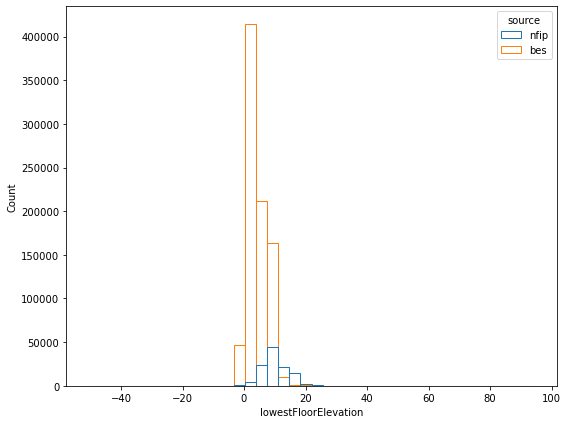

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=distribution_df,
    x="lowestFloorElevation",
    bins=40,
    ax=ax,
    fill=False,
    hue="source",
)

plt.tight_layout()

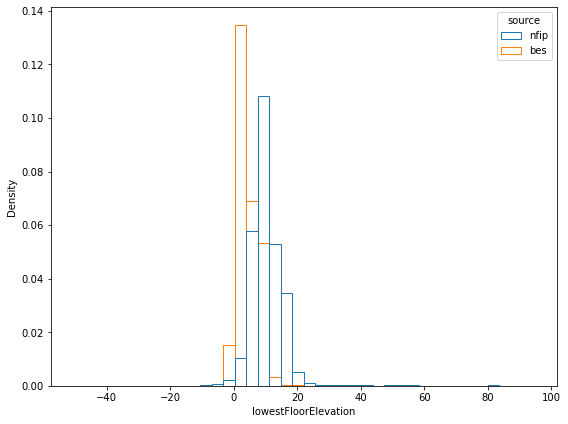

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=distribution_df,
    x="lowestFloorElevation",
    bins=40,
    ax=ax,
    fill=False,
    hue="source",
    stat="density",
    common_norm=False
)

plt.tight_layout()

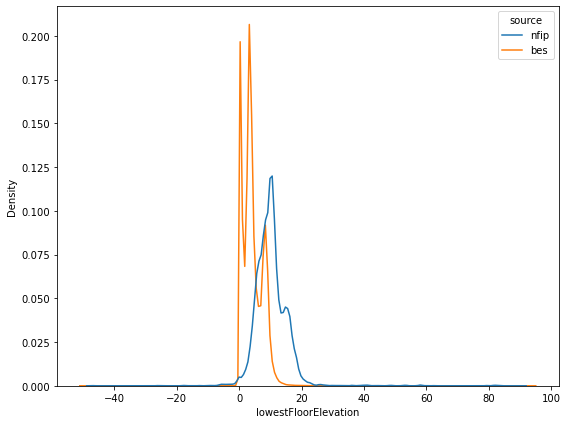

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=distribution_df,
    x="lowestFloorElevation",
    ax=ax,
    hue="source",
    common_norm=False
)

plt.tight_layout()

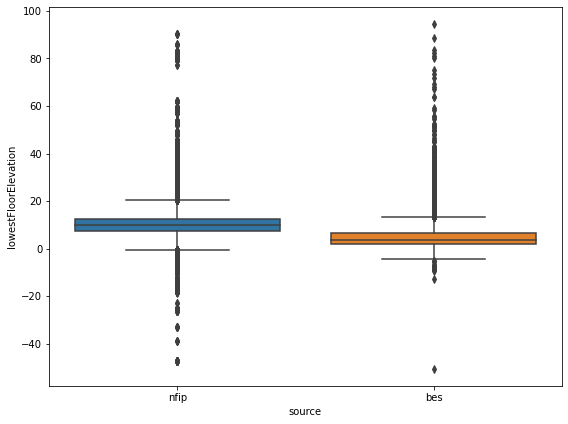

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=distribution_df,
    x="source",
    y="lowestFloorElevation",
    ax=ax
)

plt.tight_layout()

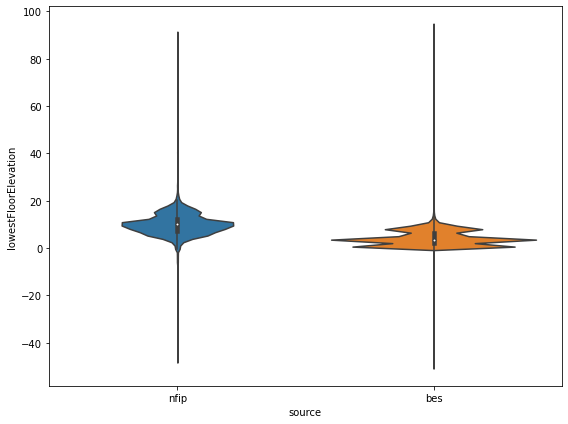

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(
    data=distribution_df,
    x="source",
    y="lowestFloorElevation",
    ax=ax
)

plt.tight_layout()